[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drarkadeep/dangerously-devilish-notebooks/blob/main/nma/fMRI/second_level_glm.ipynb)

# Import necessary libraries 

In [ ]:
!pip install nilearn

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn import plotting, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os, requests
import tarfile
import ipywidgets as widgets
%matplotlib inline

# Get the data

### Download

In [2]:
fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Unzip

In [3]:
HCP_DIR = "./hcp_task"
if not os.path.exists(HCP_DIR):
    with tarfile.open(fname) as tfile:
      tfile.extractall('.')

### Load subjects, runs & conditions

In [4]:
subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')
runs = ['LR','RL']
conditions = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win','neut']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

# First Level GLM

### Load single subject data

In [5]:
def load_single_timeseries(subject, experiment, run):
  bold_run  = runs[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  ts -= ts.mean(axis=1, keepdims=True)
  ts /= ts.std(axis=1, keepdims=True)
  return ts.T

bold_data = load_single_timeseries(subjects[0], "GAMBLING", 0)

### Create design matrix with HRF and Event list

In [6]:
def create_hrf(tr, oversampling=16, time_length=32, onset=0):
    dt = tr / oversampling
    time_stamps = np.linspace(onset, time_length, int(time_length / dt))
    peak_delay = 6
    undershoot_delay = 16
    peak_disp = 1
    undershoot_disp = 1
    peak_scale = 1
    undershoot_scale = 0.25
    peak = stats.gamma.pdf(time_stamps, peak_delay / peak_disp, loc=onset, scale=peak_disp)
    undershoot = stats.gamma.pdf(time_stamps, undershoot_delay / undershoot_disp, loc=onset, scale=undershoot_disp)
    hrf = peak_scale * peak - undershoot_scale * undershoot
    hrf /= hrf.max()
    return hrf

def get_events(subject, experiment, run):
    task_key = f'tfMRI_{experiment}_{runs[run]}'
    events_data = []
    for cond in conditions[experiment]['cond']:
        ev_file = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}_event.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        df = pd.DataFrame({
            'onset': ev_array[0],
            'duration': ev_array[1],
            'amplitude': ev_array[2],
            'trial_type': cond
        })
        events_data.append(df)
    events = pd.concat(events_data, ignore_index=True)
    events = events.sort_values('onset')    
    return events
    

def create_design_matrix(subject, experiment, run, TR, n_scans):
    events = get_events(subject, experiment, run)
    hrf = create_hrf(TR)
    design_matrix = np.zeros((n_scans, len(conditions[experiment]['cond'])))
    for i, cond in enumerate(conditions[experiment]['cond']):
        cond_events = events[events['trial_type'] == cond]
        regressor = np.zeros(n_scans)
        for _, event in cond_events.iterrows():
            onset = int(event['onset'] / TR)
            duration = int(event['duration'] / TR)
            amplitude = event['amplitude']
            regressor[onset:onset+duration] = amplitude
        convolved_regressor = np.convolve(regressor, hrf)[:n_scans]
        design_matrix[:, i] = convolved_regressor
    design_matrix = np.column_stack([np.ones(n_scans), design_matrix])
    column_names = ['constant'] + conditions[experiment]['cond']
    design_matrix_df = pd.DataFrame(design_matrix, columns=column_names)
    return design_matrix_df

design_matrix = create_design_matrix(subjects[0], "GAMBLING", 0, 0.72, 253)

### Visualise Design Matrix

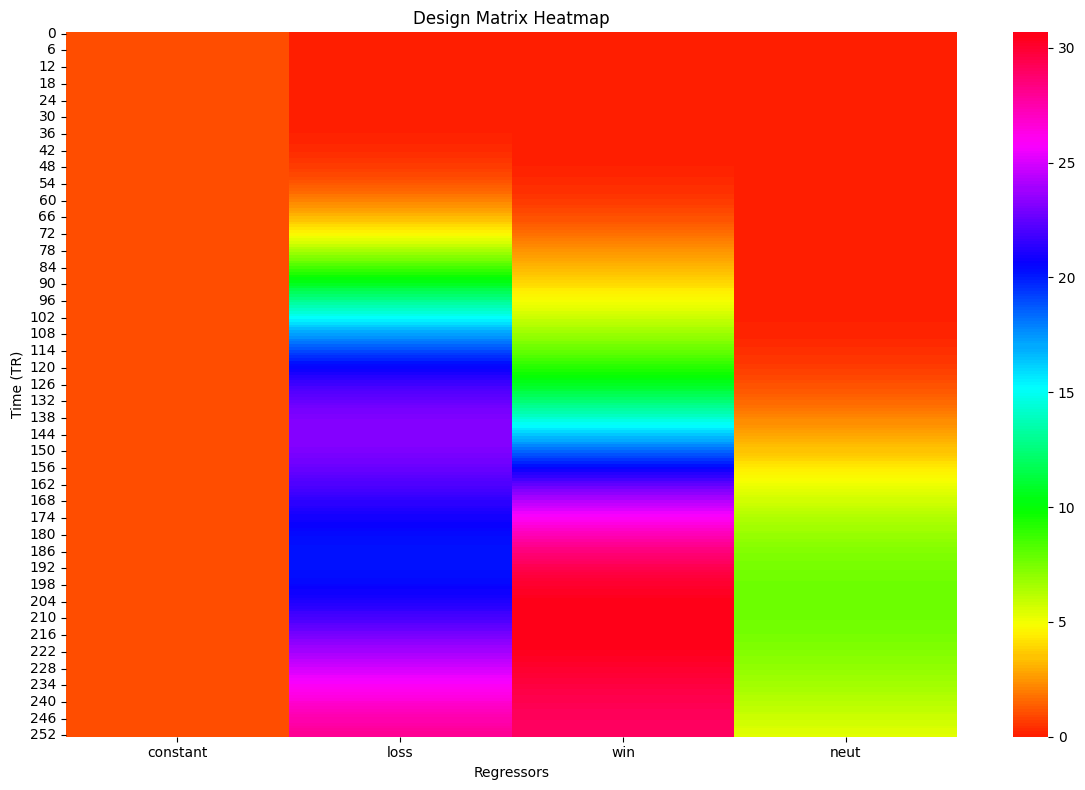

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(design_matrix, cmap='hsv', center=15)
plt.title('Design Matrix Heatmap')
plt.xlabel('Regressors')
plt.ylabel('Time (TR)')
plt.tight_layout()
plt.show()

### Fitting the model

In [8]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_df = pd.DataFrame({'region': regions[0],
                        'network' : regions[1],
                        'hemi' : ['Right']*int(180) + ['Left']*int(180)
                        })

In [12]:
results = []

for roi in range(360):
    model = sm.OLS(bold_data[:, roi], design_matrix).fit()
    results.append({
        'ROI': roi,
        'coefficients': np.array(model.params),
        'p_values': np.array(model.pvalues),
        't_values': np.array(model.tvalues),
        'rsquared': model.rsquared
    })

results_df = pd.DataFrame(results)    
results_df["region"] = results_df["ROI"].map(region_df["region"])
results_df["network"] = results_df["ROI"].map(region_df["network"])
results_df["hemi"] = results_df["ROI"].map(region_df["hemi"])   

results_df.to_csv("test.csv", index=False)
# print(results_df)

### Visualizing Coefficients for each ROI

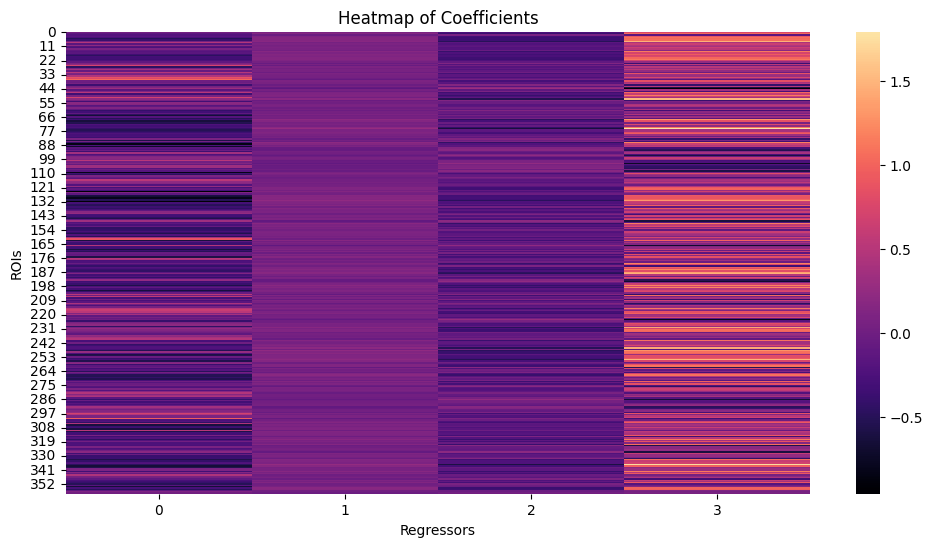

In [9]:
coefficients_matrix = np.stack(results_df['coefficients'].values)
plt.figure(figsize=(12, 6))
sns.heatmap(coefficients_matrix, annot=False, cmap='magma', center=0.5)
plt.title('Heatmap of Coefficients')
plt.xlabel('Regressors')
plt.ylabel('ROIs')
plt.show()

### Visualizing p-values per regressor for each ROI

We see lots of significant results which might occur because of comparing across 360 ROIs.

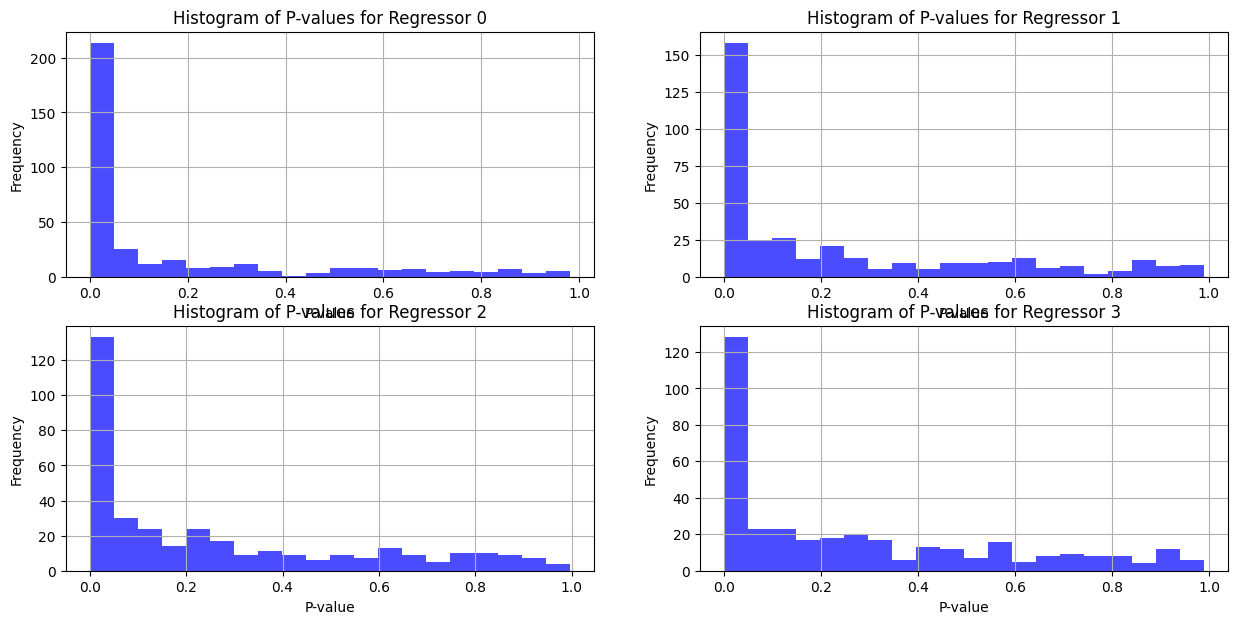

In [10]:
p_values_matrix = np.stack(results_df['p_values'].values)
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].hist(p_values_matrix[:, i], bins=20, alpha=0.7, color='blue')
    axs[i].set_title(f'Histogram of P-values for Regressor {i}')
    axs[i].set_xlabel('P-value')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

### Applying Bonferroni Correction to p-values

Number of significant ROIs drops by a lot

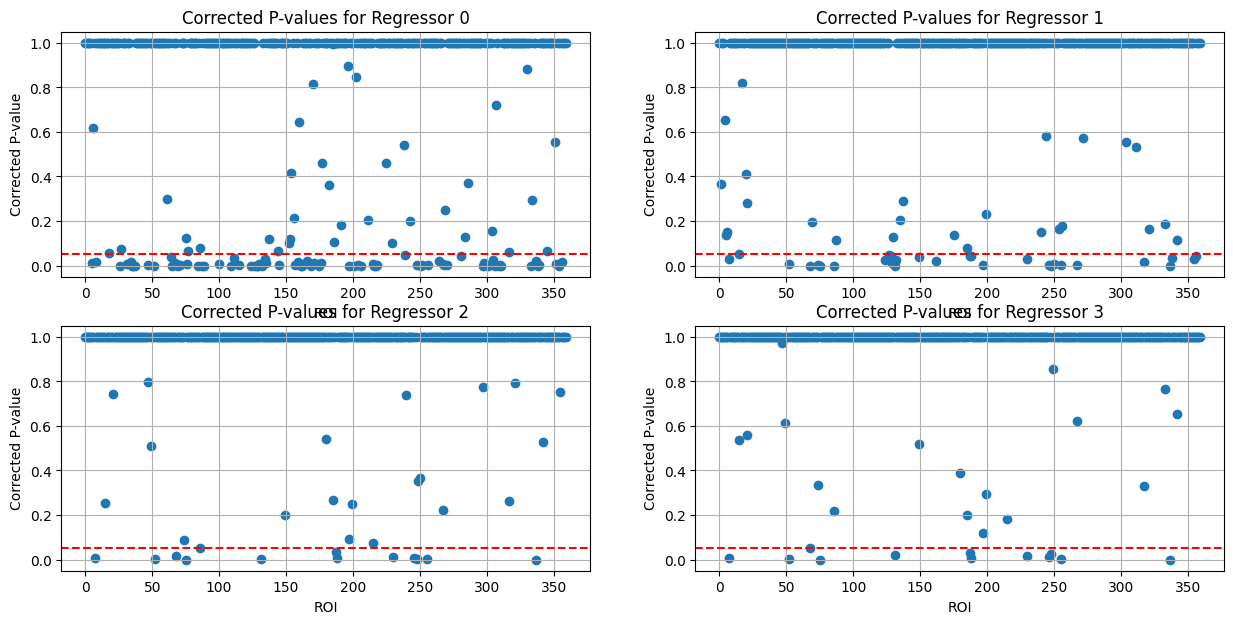

In [11]:
p_values_flat = p_values_matrix.flatten()
corrected_p_values = multipletests(p_values_flat, alpha=0.05, method='bonferroni')[1]
corrected_p_values_matrix = corrected_p_values.reshape(360, p_values_matrix.shape[1])

fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(results_df['ROI'], corrected_p_values_matrix[:, i])
    axs[i].axhline(y=0.05, color='r', linestyle='--')
    axs[i].set_title(f'Corrected P-values for Regressor {i}')
    axs[i].set_xlabel('ROI')
    axs[i].set_ylabel('Corrected P-value')
    axs[i].grid(True)

### Applying False Positive Discovery Rate Correction to p-values

This is less conservative, so, number of significant ROIs drop somewhat. 

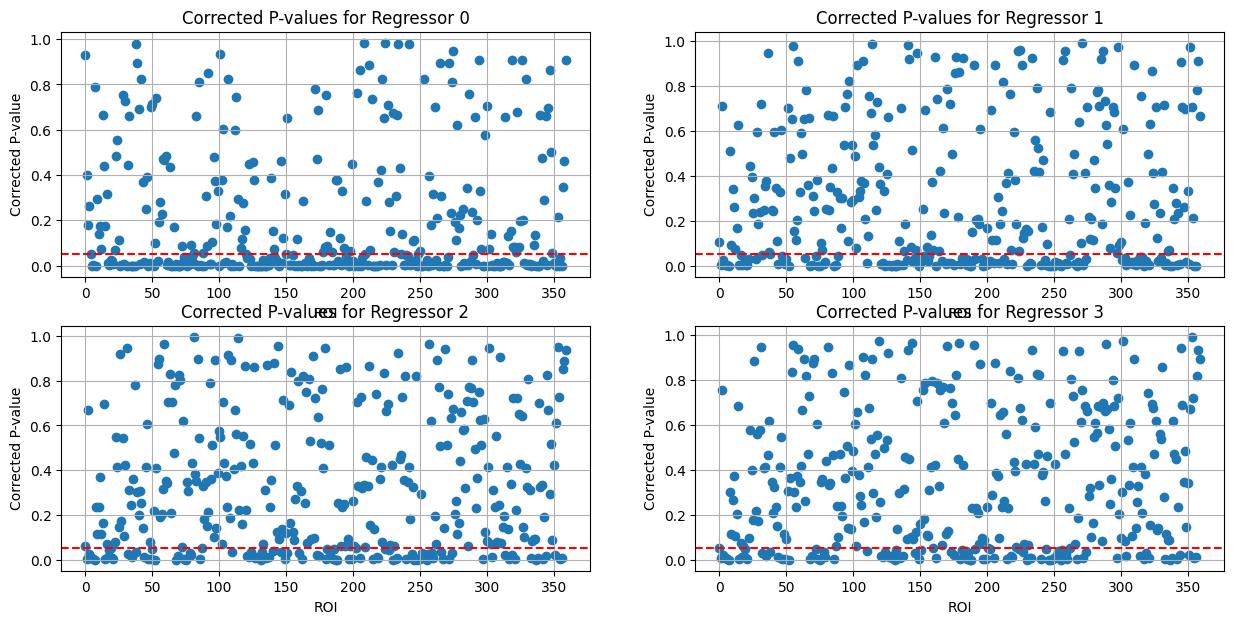

In [12]:
p_values_flat = p_values_matrix.flatten()
corrected_p_values = multipletests(p_values_flat, alpha=0.05, method='fdr_bh')[1]
corrected_p_values_matrix = corrected_p_values.reshape(360, p_values_matrix.shape[1])

fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(results_df['ROI'], corrected_p_values_matrix[:, i])
    axs[i].axhline(y=0.05, color='r', linestyle='--')
    axs[i].set_title(f'Corrected P-values for Regressor {i}')
    axs[i].set_xlabel('ROI')
    axs[i].set_ylabel('Corrected P-value')
    axs[i].grid(True)

# Second Level GLM

### Running first-level GLM with Bonferroni correction for all subjects and runs

In [13]:
def run_first_level_glm(subject, experiment, run, TR, correction):
    bold_data = load_single_timeseries(subject, experiment, run)
    n_scans = bold_data.shape[0]
    design_matrix = create_design_matrix(subject, experiment, run, TR, n_scans)
    
    results = []
    n_rois = 360
    
    for roi in range(n_rois):
        model = sm.OLS(bold_data[:, roi], design_matrix).fit()
        corrected_p_values = multipletests(np.array(model.pvalues).flatten(), alpha=0.05, method=correction)[1]
        
        results.append({
            'ROI': roi,
            'coefficients': np.array(model.params),
            'p_values': np.array(model.pvalues),
            'corrected_p_values': corrected_p_values,
            't_values': np.array(model.tvalues),
            'rsquared': model.rsquared
        })
    return pd.DataFrame(results)

all_subjects_results = []
TR = 0.72
for subject in subjects:
    for run in range(2):
        subject_results = run_first_level_glm(subject, 'GAMBLING', run, TR, "fdr_bh")
        all_subjects_results.append(subject_results)

### Prepare data and run Second Level GLM with FDR correction

In [14]:
def prepare_second_level_data(all_subjects_results, regressor_index):
    group_data = []
    for subject_results in all_subjects_results:
        group_data.append(subject_results['coefficients'].apply(lambda x: x[regressor_index]))
    return np.array(group_data)

def run_second_level_glm(group_data):
    n_rois = group_data.shape[1]
    results = []    
    for roi in range(n_rois):
        t_stat, p_value = stats.ttest_1samp(group_data[:, roi], 0)        
        results.append({
            'ROI': roi,
            't_statistic': t_stat,
            'p_value': p_value
        })    
    results_df = pd.DataFrame(results)    
    corrected_p_values = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')[1]
    results_df['corrected_p_value'] = corrected_p_values    
    return results_df

second_level_results = {}
n_regressors = len(all_subjects_results[0]['coefficients'][0])

for regressor_index in range(n_regressors):
    group_data = prepare_second_level_data(all_subjects_results, regressor_index)
    second_level_results[f'Regressor_{regressor_index}'] = run_second_level_glm(group_data)

### Plotting p-values across ROIs

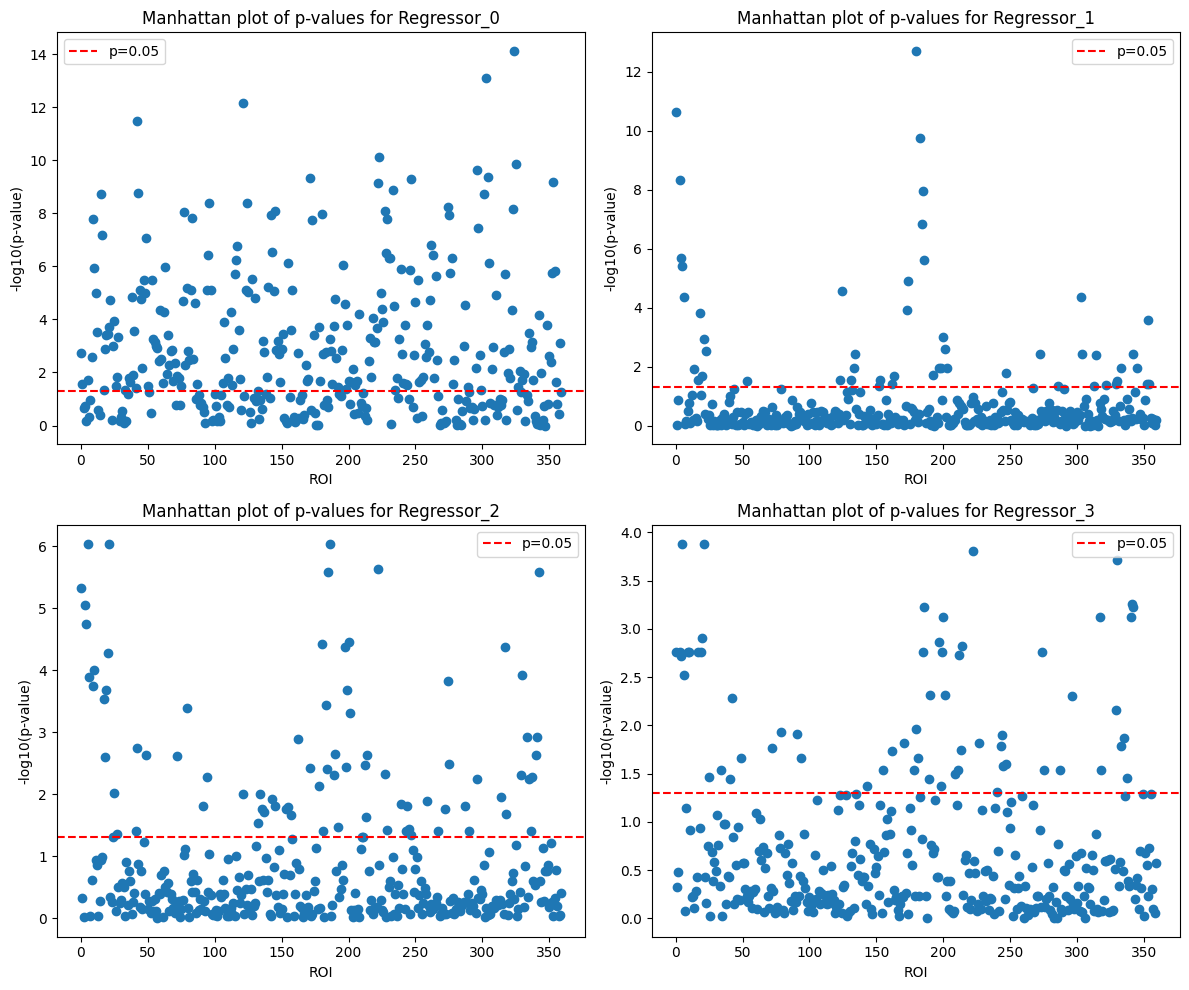

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
for i, (regressor, results) in enumerate(second_level_results.items()):
    axs[i].plot(results['ROI'], -np.log10(results['corrected_p_value']), 'o')
    axs[i].axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
    axs[i].set_xlabel('ROI')
    axs[i].set_ylabel('-log10(p-value)')
    axs[i].set_title(f'Manhattan plot of p-values for {regressor}')
    axs[i].legend()
plt.tight_layout()
plt.show()

### Plotting t-stats across ROIs

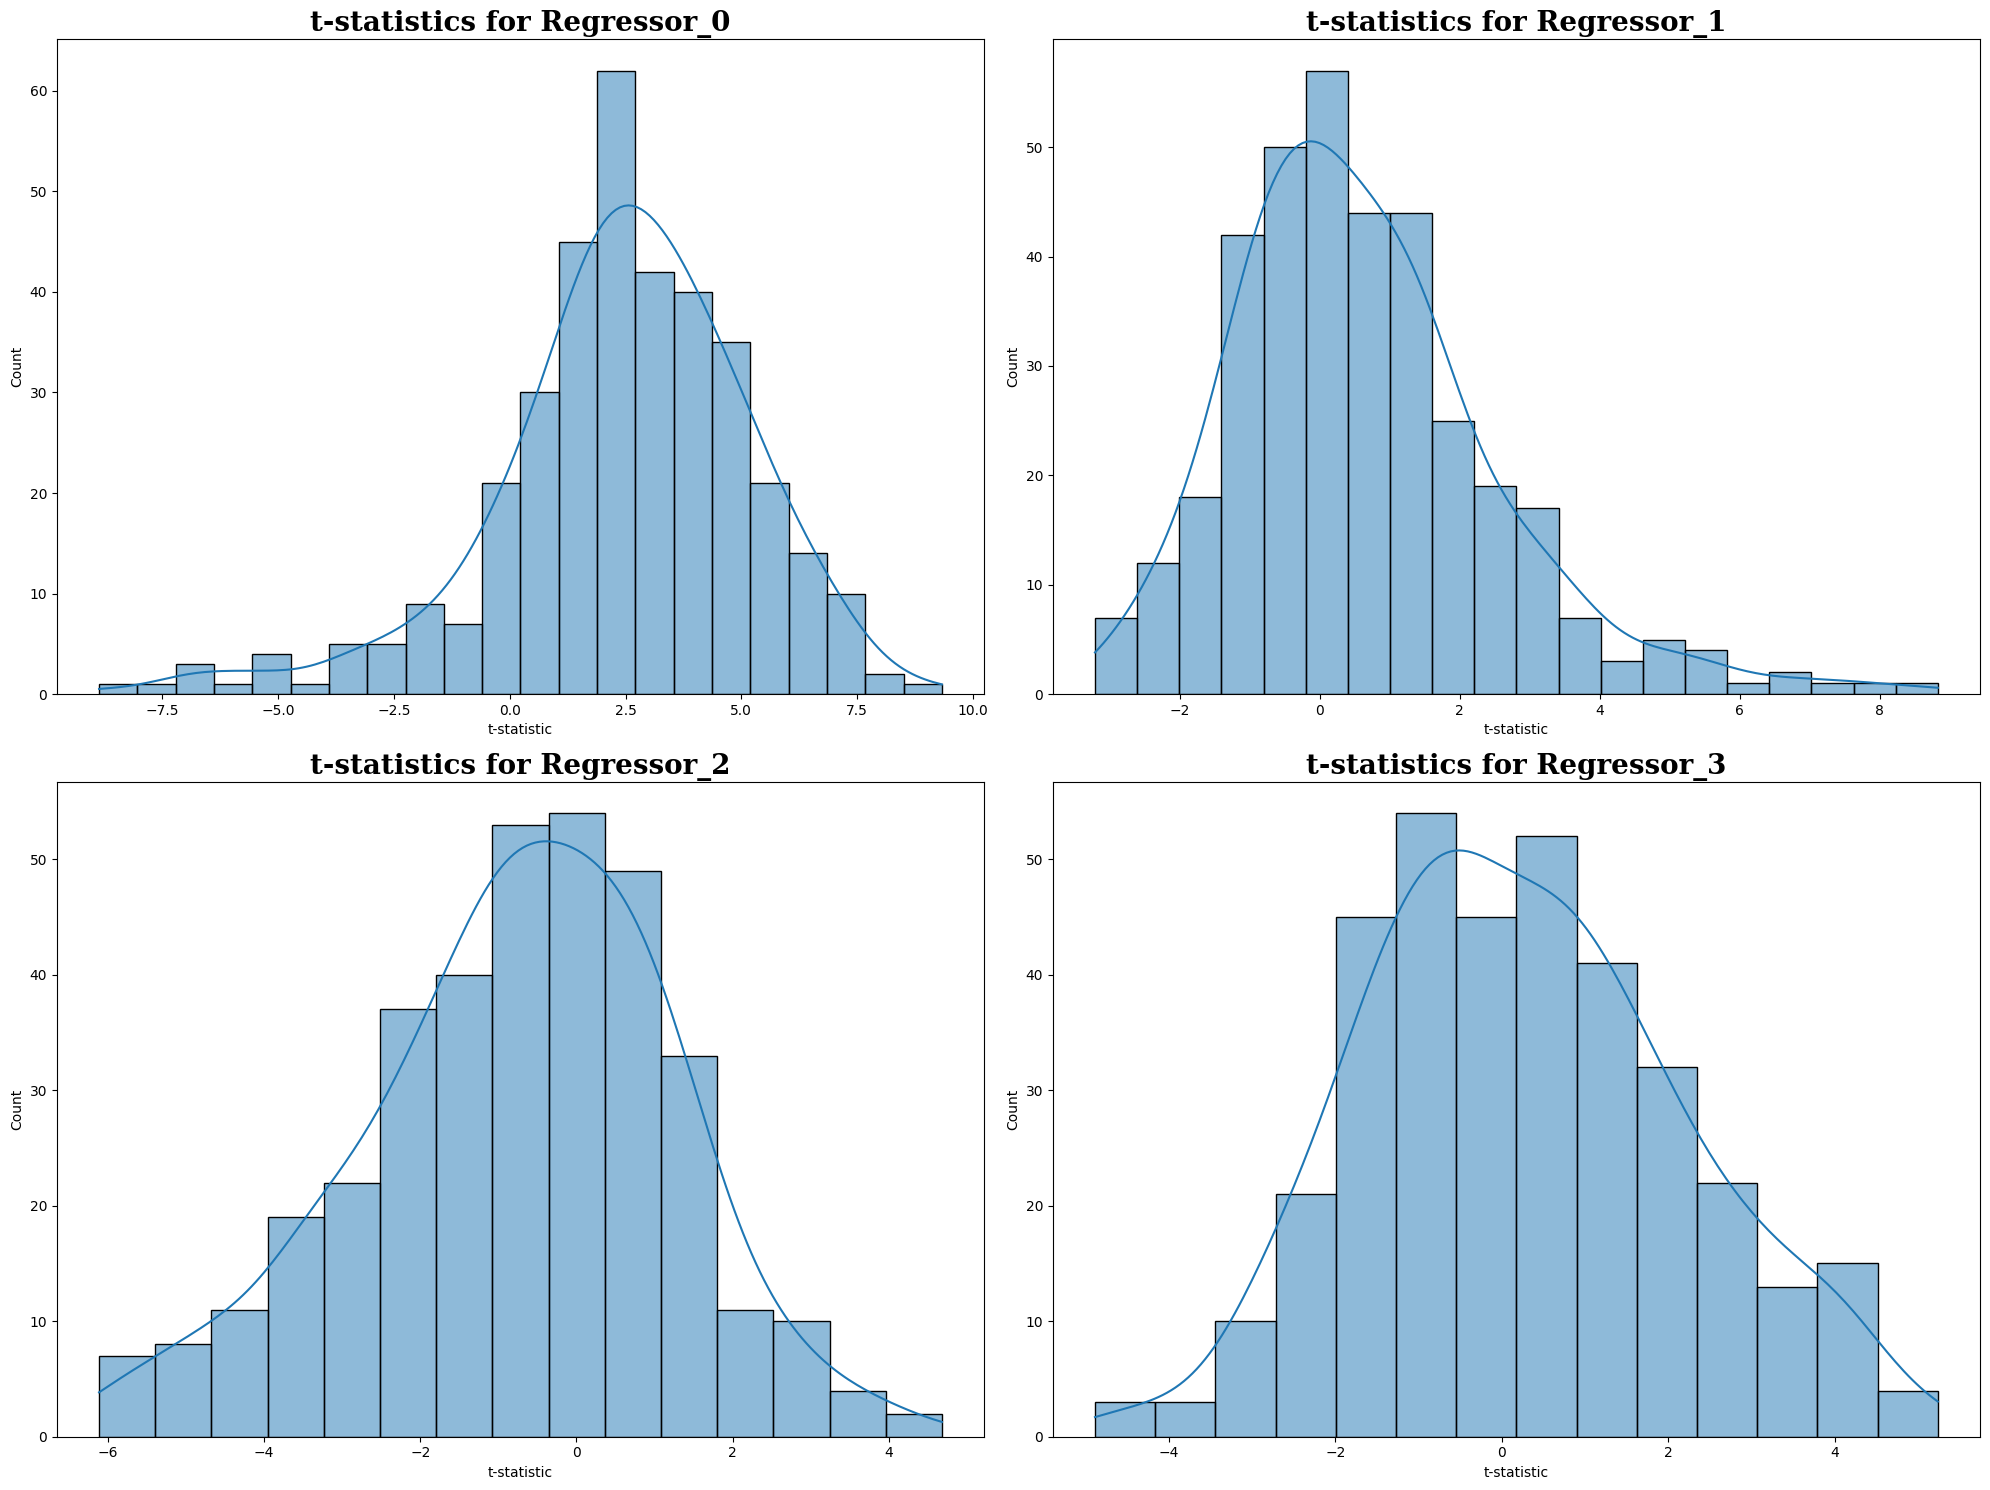

In [16]:
plt.figure(figsize=(20, 15))
for i, (regressor, results) in enumerate(second_level_results.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(results['t_statistic'], kde=True)
    plt.xlabel('t-statistic')
    plt.ylabel('Count')
    plt.title(f't-statistics for {regressor}', fontdict={'fontsize': 20, 'fontweight': 'bold', 'family': 'serif'})

plt.tight_layout()
plt.show()

### Top 10 ROIs for each Regressor

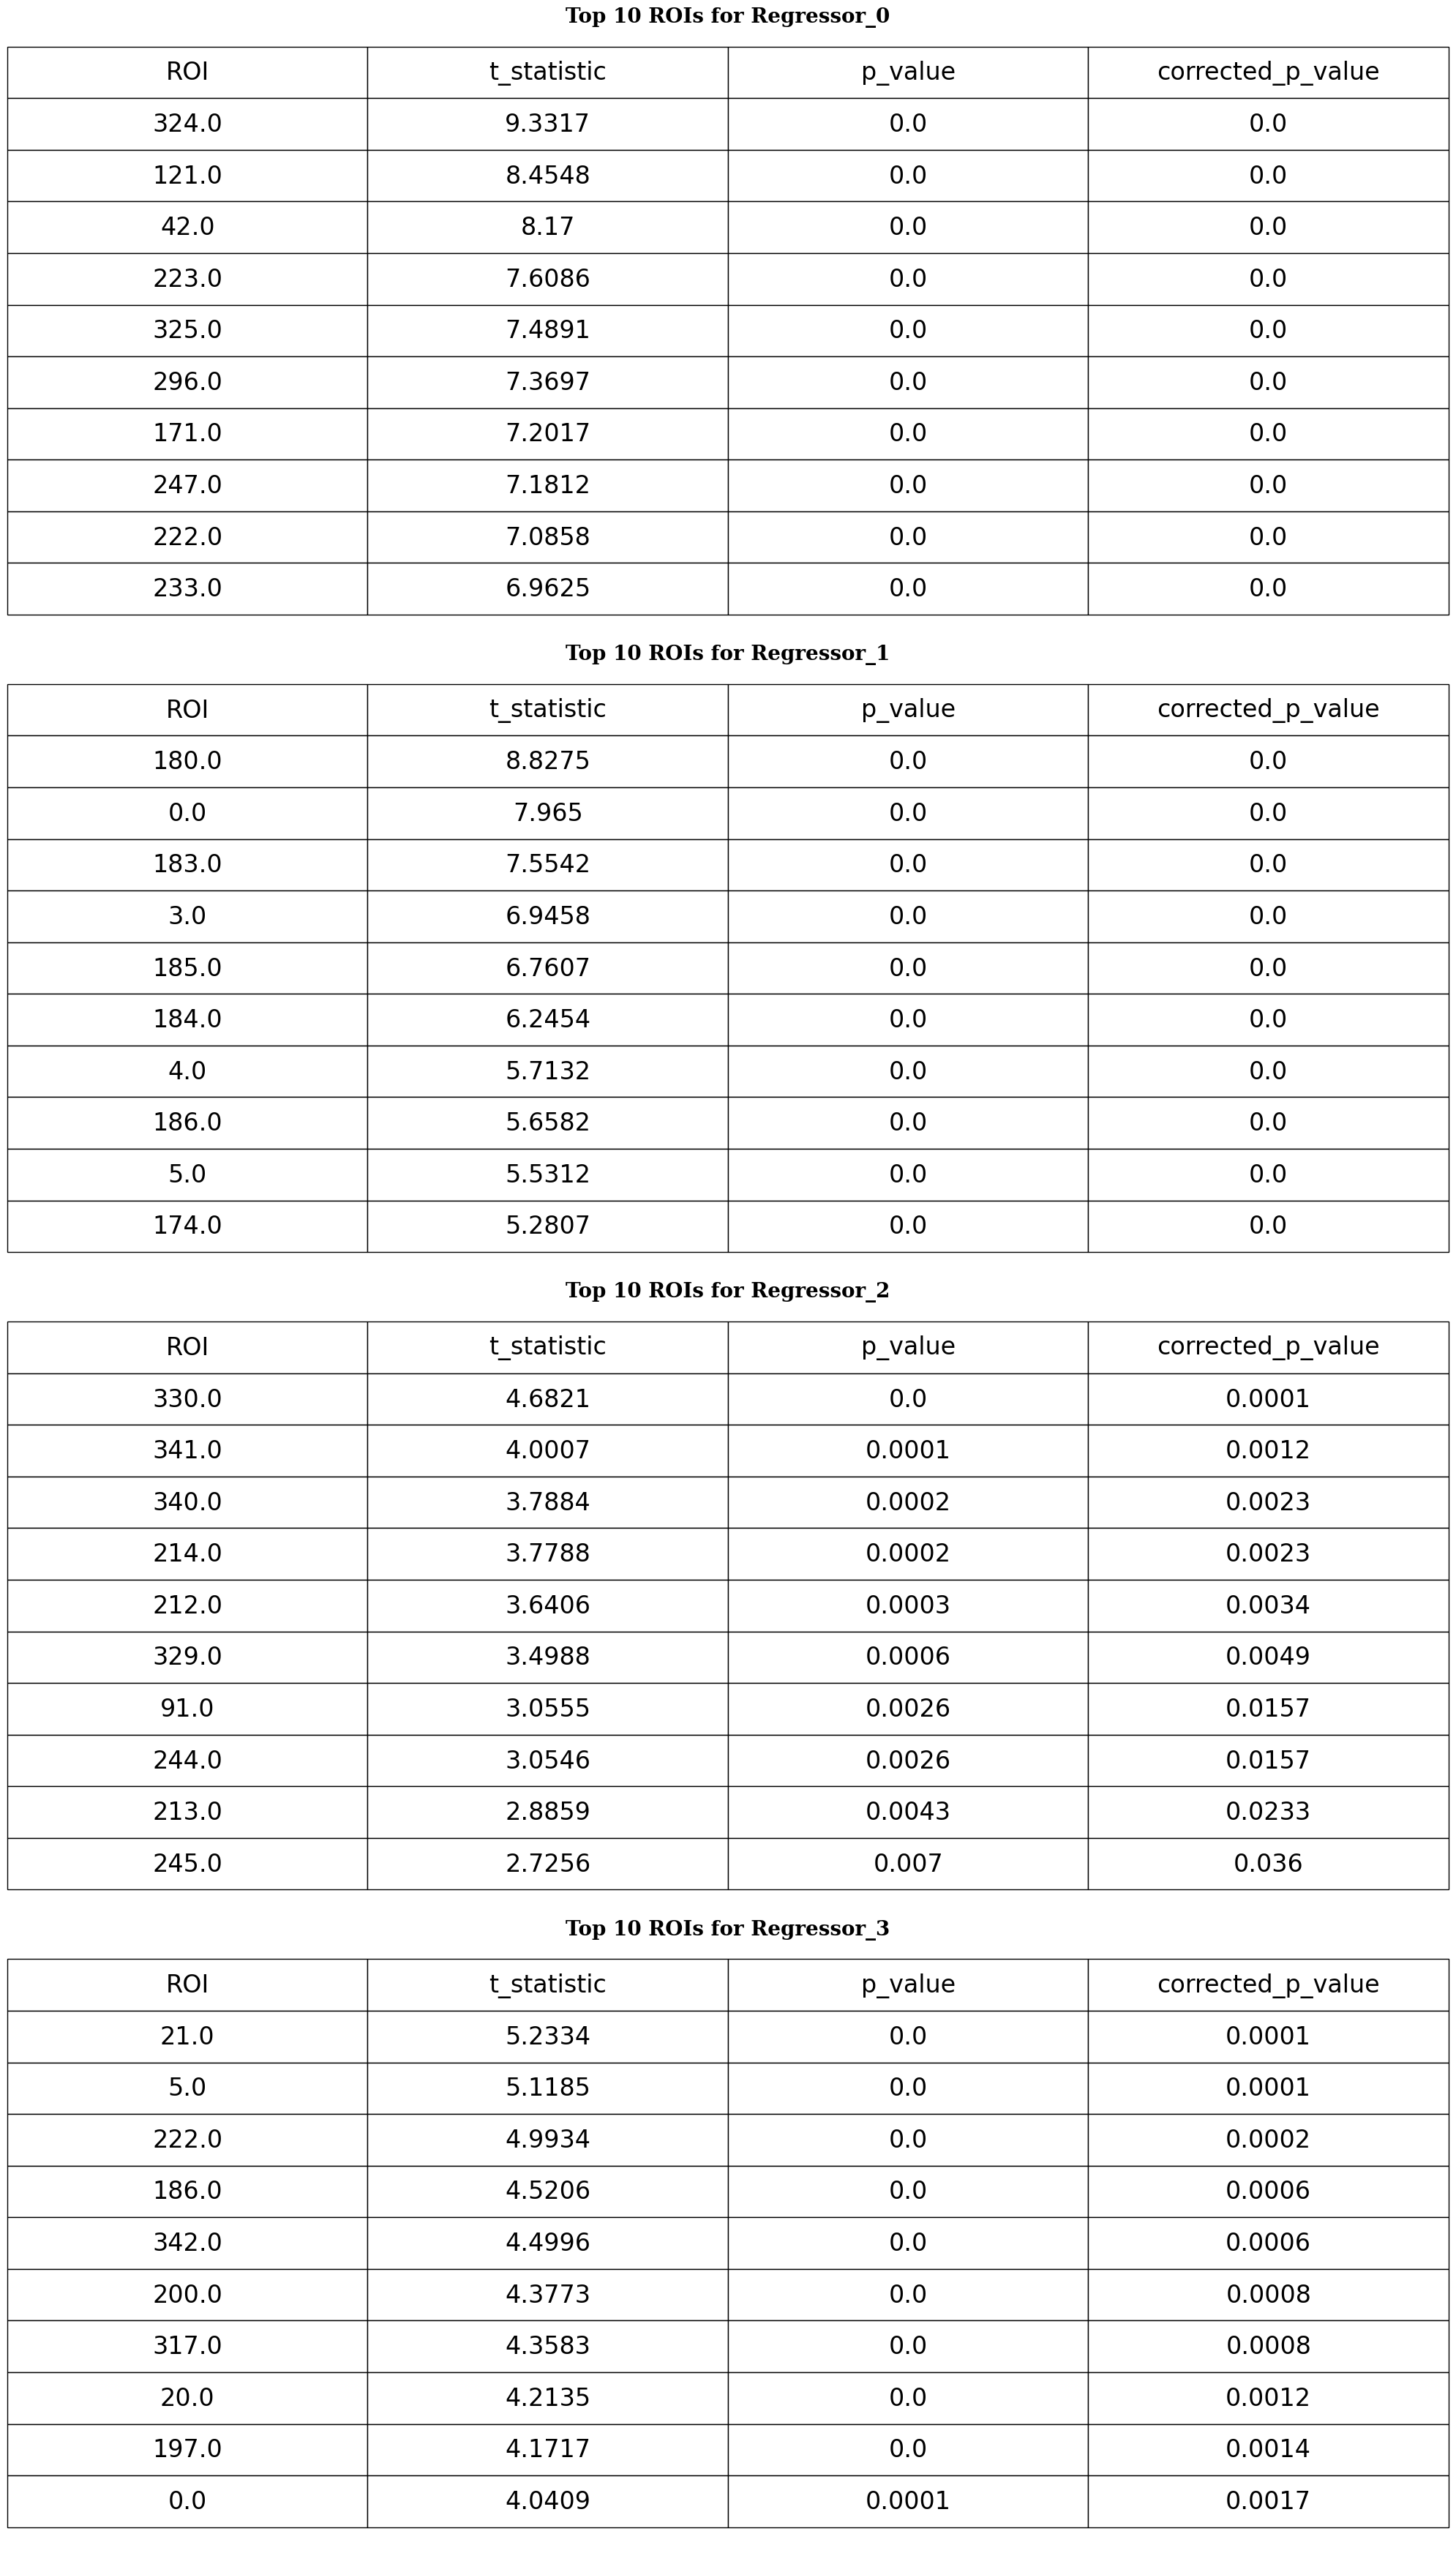

In [17]:
fig, axs = plt.subplots(4, 1, figsize=(20, 35))
axs = axs.flatten()

for i, (regressor, results) in enumerate(second_level_results.items()):
    ax = axs[i]
    ax.axis('off')
    top_10_rois = results.nlargest(10, 't_statistic')
    table = ax.table(cellText=top_10_rois.values.round(4),
                     colLabels=top_10_rois.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(24)
    table.scale(1, 3)
    ax.set_title(f'Top 10 ROIs for {regressor}', fontdict={'fontsize': 20, 'fontweight': 'bold', 'family': 'serif'})

plt.tight_layout()
plt.show()

# Plot on Brain

### Download and set-up atlas

In [18]:
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
with np.load(fname) as dobj:
  atlas = dict(**dobj)
fsaverage = datasets.fetch_surf_fsaverage()

### Plotting T-statistics of Regressors

Run the code to plot

In [ ]:
def plot_brain(regressor, plot, vmax, threshold):
    surf_contrast = np.array(second_level_results[regressor]["t_statistic"])[atlas["labels_L"]]
    brain_view = plotting.view_surf(fsaverage[f'{plot}_left'],
                   surf_contrast, cmap="magma",
                   vmax=vmax, threshold=threshold)
    return brain_view

brain_plot = widgets.interact(plot_brain, regressor=widgets.Dropdown(options={"Constant":'Regressor_0',"Loss":'Regressor_1',"Win":'Regressor_2',"Neutral":'Regressor_3'}, value='Regressor_1', description='Regressor:'), plot=widgets.Dropdown(options=['pial', 'infl', 'sphere'], value='infl', description='Plot Type:'), vmax=widgets.FloatSlider(min=0, max=10, value=4, step=0.1, description='VMax:'), threshold=widgets.IntSlider(min=0, max=5, value=0, description='Threshold:'))
